In [6]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

In [7]:
sent = np.load("en.1.npz")
T_proj = sent['projection_tensor']
source_langs = sent['source_languages']

In [8]:
T_proj[:,:,0].shape

(11, 12)

In [9]:
D = pd.DataFrame(T_proj[0])
M = T_proj[0] - T_proj[0].min()
M

array([[ 0.01857725,  0.00966962,  0.02829428,  0.01531986,  0.00683147,
         0.01329688,  0.00739149,  0.        ,  0.01131141,  0.        ,
         0.00524848,  0.        ,  0.00732743,  0.00898026,  0.00594038,
         0.02999028,  0.00858438,  0.01862544,  0.02844567,  0.01602879],
       [ 0.04703689,  0.03116582,  0.02829428,  0.04924324,  0.02471588,
         0.03913895,  0.04288484,  0.        ,  0.0407136 ,  0.        ,
         0.02916945,  0.        ,  0.02585639,  0.03144237,  0.02750928,
         0.02999028,  0.04206643,  0.06933466,  0.02844567,  0.04808179],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.02088914,  0.        ,  0.0285683 ,  0.        ,
         0.02916945,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.27499539,  0.        ,  0.        ,  0.        ],
       [ 0.66572862,  0.68992894,  0.69248163,  0.47770808,  0.68971166,
         0.07745146,  0.61163458,  0.        ,  

de


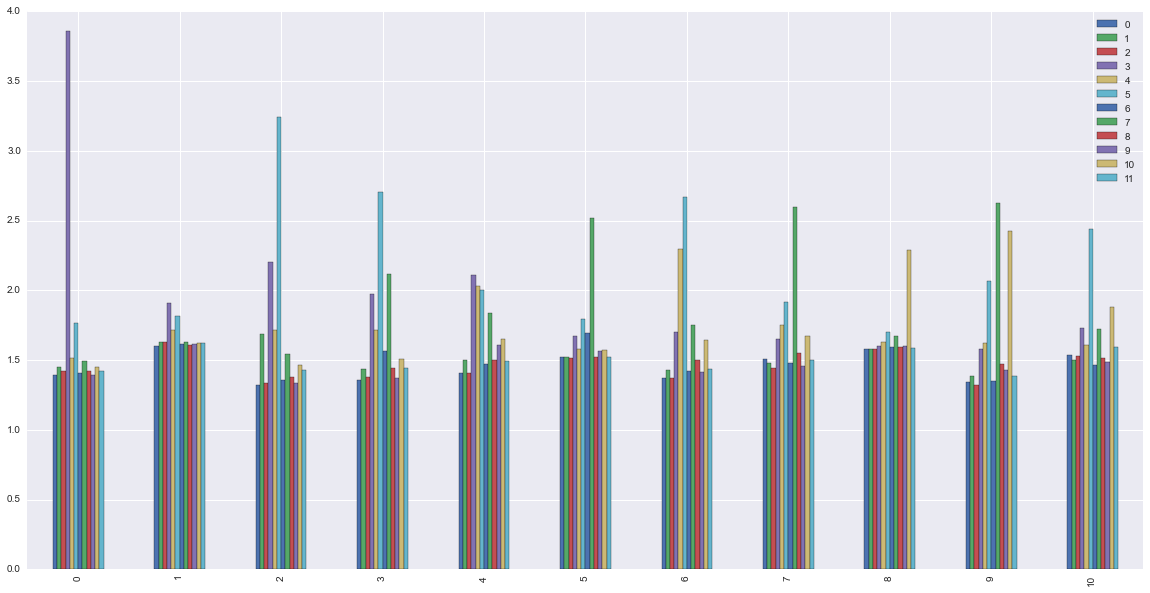

In [21]:
i = 4
print(source_langs[i])
M = T_proj[:,:,i]# - T_proj[:,:,i].min()

def softmax(matrix, temperature=1):
    m_exp = np.exp(matrix/temperature)
    return (m_exp.T / m_exp.sum(axis=1)).T

#for i in range(T_proj.shape[2]):
#    T_proj[:,:,i] = softmax(T_proj[:,:,i], 0.5)

#pd.DataFrame(softmax(M, 0.5)).plot(kind='bar', figsize=(20, 10))

# M -= M.min(axis=1)

#pd.DataFrame(M) *1

def sum_normalize(T_proj):
    return T_proj.sum(axis=2)

M_voted = sum_normalize(T_proj)
M_voted
pd.DataFrame(M_voted).plot(kind='bar', figsize=(20, 10))
